<a href="https://colab.research.google.com/github/sobiness/Sentiment-Analysis-on-twitter-dataset_sobika/blob/main/SentimentAnalysis_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:
import re
import pickle
import numpy as np
import pandas as pd

#plotting
import seaborn as sns
import matplotlib.pyplot as plt

#nltk
from nltk.stem import WordNetLemmatizer

#sklearn
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [102]:
# Importing the dataset
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('/content/testdata.manual.2009.06.14.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS, error_bad_lines=False,lineterminator='\n')
df.head(5)
df = df[df['target'] != 2]
df.head(5)

,target,ids,date,flag,user,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


In [103]:
print('length of data is', len(df))
df.info()
np.sum(df.isnull().any(axis=1))
df['target'].unique()

length of data is 359
<class 'pandas.core.frame.DataFrame'>
Int64Index: 359 entries, 0 to 497
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  359 non-null    int64 
 1   ids     359 non-null    int64 
 2   date    359 non-null    object
 3   flag    359 non-null    object
 4   user    359 non-null    object
 5   text    359 non-null    object
dtypes: int64(2), object(4)
memory usage: 19.6+ KB


array([4, 0])

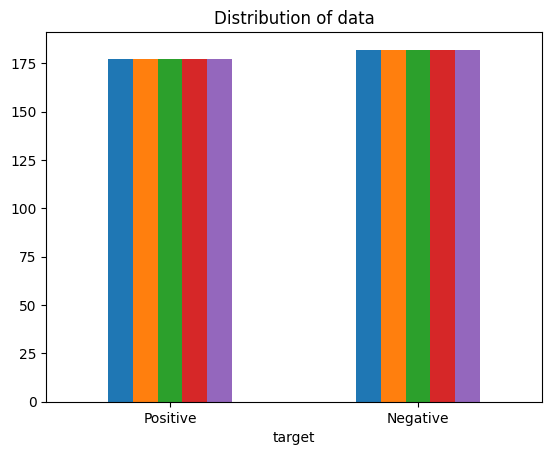

In [104]:
# Plotting the distribution for dataset.
ax = df.groupby('target').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Positive','Negative'], rotation=0)
# Storing data in lists.
text, sentiment = list(df['text']), list(df['target'])

In [105]:
data=df[['text','target']]

In [106]:
data['target'] = data['target'].replace(4,1)
#data['target'] = data['target'].replace(0,-1)
#data['target'] = data['target'].replace(2,0)

In [107]:
#separating positive and negative tweets
data_pos = data[data['target'] == 1]
data_neg = data[data['target'] == 0]
#data_neu = data[data['target'] == 0]

In [108]:
dataset = pd.concat([data_pos, data_neg])

In [109]:
#making all text to lowercase
dataset['text']=dataset['text'].str.lower()
dataset['text'].tail()

485    monday already. iran may implode. kitchen is a...
490    i just created my first latex file from scratc...
494    on that note, i hate word. i hate pages. i hat...
496    trouble in iran, i see. hmm. iran. iran so far...
497    reading the tweets coming out of iran... the w...
Name: text, dtype: object

In [110]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [111]:
STOPWORDS = set(stopwordlist)

#function1
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))


import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations

#function2
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))

#function3
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))

#function4
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))

#tokenizing
dataset['text'] = dataset['text'].astype(str)
dataset['text'] = dataset['text'].fillna('')

from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)

#stemming
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))

#lemmatizer
nltk.download('wordnet')
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))

X=data.text
y=data.target

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [112]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=10000)
vectoriser.fit(X)
X= vectoriser.transform(X)

In [113]:
!pip install scikit-learn
!pip install joblib

In [114]:
from nltk.classify import naivebayes
import joblib

#loading the models
svm_model = joblib.load('svc_model.pkl')
logistic_model = joblib.load('lr_model.pkl')
naivebayes_model = joblib.load('bnb_model.pkl')

#predictions
svm_predictions = svm_model.predict(X)
logistic_predictions = logistic_model.predict(X)
naivebayes_predections = naivebayes_model.predict(X)




In [115]:
print("Logistic Regression Predictions (First 10):")
print(logistic_predictions[:50])

# Print predicted labels from SVM model
print("SVM Predictions (First 10):")
print(svm_predictions[:20])

# Print predicted labels from Naive Bayes model
print("Naive Bayes Predictions (First 10):")
print(naivebayes_predections[:20])

Logistic Regression Predictions (First 10):
[0 1 1 0 1 1 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 0 0 1 0 0 1 1 0 1 0 0]
SVM Predictions (First 10):
[0 1 1 0 1 1 1 0 1 1 0 0 0 0 0 0 0 1 0 0]
Naive Bayes Predictions (First 10):
[0 1 1 0 1 1 1 0 1 1 0 0 0 0 0 0 0 1 0 1]


In [116]:
import warnings
warnings.filterwarnings("ignore")
# Classification report for logistic regression
print("Classification Report - Logistic Regression:")
print(classification_report(y, logistic_predictions))

# Classification report for SVM
print("Classification Report - SVM:")
print(classification_report(y, svm_predictions))

# Classification report for Naive Bayes
print("Classification Report - Naive Bayes:")
print(classification_report(y, naivebayes_predections))

Classification Report - Logistic Regression:
              precision    recall  f1-score   support

           0       0.50      0.67      0.57       177
           1       0.51      0.34      0.41       182

    accuracy                           0.50       359
   macro avg       0.50      0.50      0.49       359
weighted avg       0.50      0.50      0.49       359

Classification Report - SVM:
              precision    recall  f1-score   support

           0       0.49      0.67      0.56       177
           1       0.49      0.31      0.38       182

    accuracy                           0.49       359
   macro avg       0.49      0.49      0.47       359
weighted avg       0.49      0.49      0.47       359

Classification Report - Naive Bayes:
              precision    recall  f1-score   support

           0       0.46      0.58      0.52       177
           1       0.46      0.35      0.39       182

    accuracy                           0.46       359
   macro avg     